# 다음에 볼 영화 예측하기

- Movielens 1M Dataset을 기반으로 Session-Based Recommendation 시스템 제작하기

In [1]:
# 모듈 import
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 전처리

### (1) Data Load

In [2]:
data_path = Path('./ml-1m')
train_path = data_path / 'ratings.dat'

In [8]:
# data_path에서 data를 불러오는 함수
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Ratings', 'Time']
    return data

In [9]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬
data

,UserId,ItemId,Ratings,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [10]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점이다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않는다. 그래서 이번에는 UserID가 SessionID 역할을 해야 한다.
- Rating 정보가 포함되어 있다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 한다.
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있다.

In [11]:
# timestamp to datetime
data['Time'] = data['Time'].map(lambda x: datetime.utcfromtimestamp(x))
data

,UserId,ItemId,Ratings,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [12]:
# 각 유저가 몇 개의 영화를 봤는지 확인
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [13]:
# User 별 수치 데이터 확인
print(f'median   : {user_length.median()}')
print(f'mean     : {user_length.mean()}')
print(f'min      : {user_length.min()}')
print(f'max      : {user_length.max()}')
print(f'quantile : {user_length.quantile(0.999)}')

median   : 96.0
mean     : 165.5975165562914
min      : 20
max      : 2314
quantile : 1343.181000000005


In [14]:
long_user = user_length[user_length==2314].index[0]

In [15]:
data[data['UserId'] == long_user][:10]

,UserId,ItemId,Ratings,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
696250,4169,3841,2,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59


- 데이터를 살펴보니 무언가 이상한 것을 느꼈다. 한 UserId에 너무 많은 값이 들어있었다. 확인해보니 해당 User의 모든 기간의 데이터였기 때문이었다.
- 우선 UserId를 하나의 Session으로 간주하고 데이터를 있는 그대로 사용해보기로 했다.

### (2) Session Length

In [16]:
# 각 세션이 몇 개의 클릭 데이터를 갖는지 확인
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [17]:
# User 별 수치 데이터 확인
print(f'median   : {session_length.median()}')
print(f'mean     : {session_length.mean()}')
print(f'min      : {session_length.min()}')
print(f'max      : {session_length.max()}')
print(f'std      : {session_length.std()}')
print(f'quantile : {session_length.quantile(0.999)}')

median   : 96.0
mean     : 165.5975165562914
min      : 20
max      : 2314
std      : 192.74702906977765
quantile : 1343.181000000005


In [18]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId'] == long_session]

,UserId,ItemId,Ratings,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


In [19]:
# session 별 누적합 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum() # 누적합
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

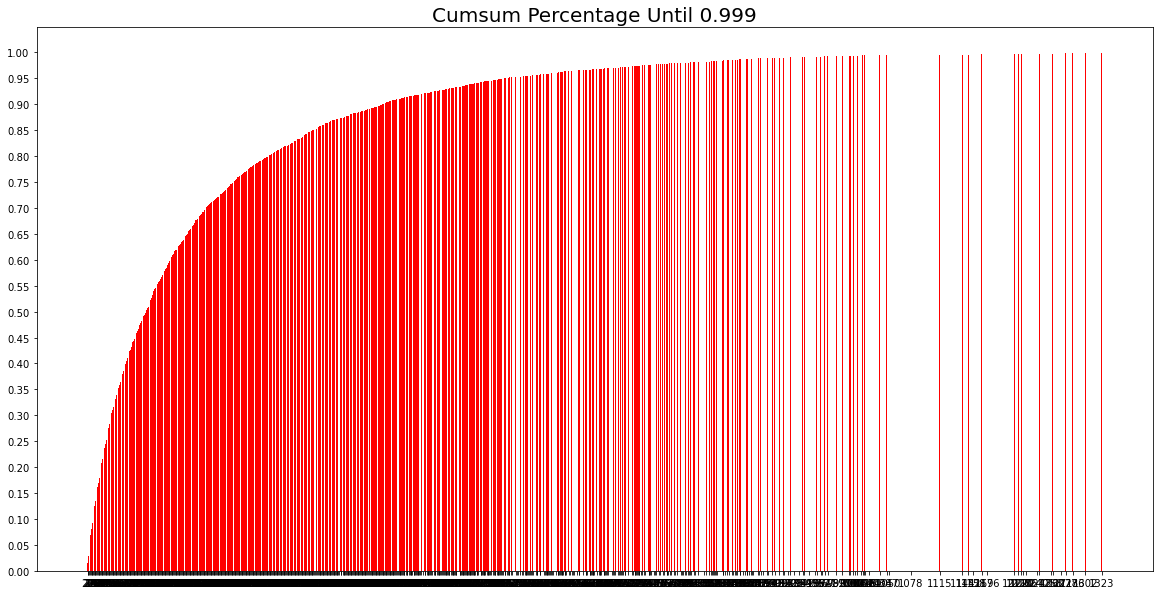

In [20]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### (3) Session Time

In [21]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [22]:
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- UserId 별로 묶었을 때 session 수가 그다지 많지 않기 때문에 모든 데이터를 사용하기로 한다.

### (4) Data Cleansing

In [23]:
# short_session을 제거한 다음에 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
# 이를 위해 반복문을 통하여 지속적으로 제거

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data 

In [24]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Ratings,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### (5) Train/Valid/Test Split

In [37]:
# UserId를 기준으로 train, val, test = 0.7, 0.2, 0.1로 분리
tr = data[data['UserId'] <= 4228]
val = data[(data['UserId'] > 4228) & (data['UserId'] <= 5436)]
test = data[data['UserId'] > 5436]

In [38]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 705588
	 Sessions: 4228
	 Items: 3416
	 First Time : 2000-08-03 14:24:25
	 Last Time : 2003-02-28 00:51:39

* valid Set Stats Info
	 Events: 193323
	 Sessions: 1208
	 Items: 3342
	 First Time : 2000-06-03 05:20:31
	 Last Time : 2003-02-28 17:49:50

* test Set Stats Info
	 Events: 100700
	 Sessions: 604
	 Items: 3172
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-28 13:12:12



In [39]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

In [40]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [41]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. 미니배치의 구성

### (1) Session Dataset

In [42]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [43]:
tr_dataset = SessionDataset(tr)
pd.options.display.max_rows = 50
tr_dataset.df.head(50)

,UserId,ItemId,Ratings,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [44]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 704344, 705565, 705588], dtype=int32)

In [45]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4225, 4226, 4227])

### (2) Session DataLoader

In [46]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [47]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Ratings,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [48]:
iter_ex = iter(tr_data_loader)

In [76]:
# 아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만든다.
# input, output, mask의 감을 잡아 보자.

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 27  77 190 221]
Label Item Idx are :       [ 28  78 191 222]
Previous Masked Input Idx are [3]


## 3. 모델 구성

### (1) Evaluation Metric
- 나에게 첫번째로 추천해준 영화가 정답 아이템의 몇 번째에 해당하는지 판단하는 지표인 MRR과 내가 선호하는 영화 중 추천해준 영화의 비율을 나타내는 Recall을 사용한다.

In [77]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### (2) Model Architecture
- 모델은 GRU를 사용한다.

In [78]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [83]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [84]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(512, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    520200    
_________________________________________________________________
dropout_1 (Dropout)          (512, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (512, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습

In [85]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [86]:
train_model(model, args)

Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0176, train_loss=6.71] 

	 - Recall@20 epoch 1: 0.091990
	 - MRR@20    epoch 1: 0.020483



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0488, train_loss=6.05] 

	 - Recall@20 epoch 2: 0.197092
	 - MRR@20    epoch 2: 0.048734



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.66]  

	 - Recall@20 epoch 3: 0.250474
	 - MRR@20    epoch 3: 0.064646



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0977, train_loss=5.48] 

	 - Recall@20 epoch 4: 0.272732
	 - MRR@20    epoch 4: 0.071853



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.105, train_loss=5.34]  

	 - Recall@20 epoch 5: 0.285466
	 - MRR@20    epoch 5: 0.077429



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0684, train_loss=5.28] 

	 - Recall@20 epoch 6: 0.293733
	 - MRR@20    epoch 6: 0.081441



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.22]  

	 - Recall@20 epoch 7: 0.300346
	 - MRR@20    epoch 7: 0.084204



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0879, train_loss=5.16] 

	 - Recall@20 epoch 8: 0.304920
	 - MRR@20    epoch 8: 0.086713



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.08]  

	 - Recall@20 epoch 9: 0.308410
	 - MRR@20    epoch 9: 0.088534



Evaluation:  54%|█████▍    | 202/375 [03:46<03:14,  1.12s/it]

	 - Recall@20 epoch 10: 0.310760
	 - MRR@20    epoch 10: 0.089821



- 모델 학습 결과를 보면 train_lost는 점점 감소하고, Recall@k 와 MRR@k 의 값이 증가하는 것을 확인할 수 있다. 따라서 정상적으로 학습되고 있는 상태라고 볼 수 있다.

## 5. 모델 테스트

In [87]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 37/195 [00:42<03:00,  1.14s/it]

	 - Recall@20: 0.308699
	 - MRR@20: 0.089137



- 추론 결과를 확인해보니 Recall@20의 값은 0.308699로, 총 20개의 영화를 추천받았을 때, 그 중에 6개가 선호하는 영화에 포함되어 있다는 이야기이다.
- MRR@20의 값은 내가 선호하는 영화의 Ranking이 있을 때, 처음으로 추천받은 영화가 얼마나 높은 Ranking의 우선순위를 갖는지 판단하는 값으로, 이 데이터에서는 영화 별 Rating Data가 있긴 하였으나 Rating이 겹치는 영화들이 많이 있고, MRR값은 항상 첫 번째로 나오는 아이템만 신경쓰는 단점을 가지고 있으므로 이번 프로젝트에서는 크게 의미를 두지 않는 것이 좋다고 판단했다.

## 6. 모델 성능 향상시키기

### (1) learning rate 변경
- 아직 더 학습할 수 있는 가능성이 있다고 생각하여 학습률을 증가시켜서 10 epoch 만큼 다시 훈련시켜 보았다.

In [88]:
args_1 = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)
model_1 = create_model(args_1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(512, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    520200    
_________________________________________________________________
dropout_2 (Dropout)          (512, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (512, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [89]:
train_model(model_1, args_1)

Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.49] 

	 - Recall@20 epoch 1: 0.299834
	 - MRR@20    epoch 1: 0.084101



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.111, train_loss=5.32]  

	 - Recall@20 epoch 2: 0.313138
	 - MRR@20    epoch 2: 0.091015



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0977, train_loss=5.19] 

	 - Recall@20 epoch 3: 0.311224
	 - MRR@20    epoch 3: 0.091581



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0957, train_loss=5.16] 

	 - Recall@20 epoch 4: 0.307975
	 - MRR@20    epoch 4: 0.091612



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.105, train_loss=5.2]  

	 - Recall@20 epoch 5: 0.306138
	 - MRR@20    epoch 5: 0.090881



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.1]  

	 - Recall@20 epoch 6: 0.305509
	 - MRR@20    epoch 6: 0.090984



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0918, train_loss=5.1]  

	 - Recall@20 epoch 7: 0.302812
	 - MRR@20    epoch 7: 0.090645



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0879, train_loss=5.14] 

	 - Recall@20 epoch 8: 0.300907
	 - MRR@20    epoch 8: 0.090448



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.105, train_loss=5.13]  

	 - Recall@20 epoch 9: 0.299263
	 - MRR@20    epoch 9: 0.089428



Evaluation:  54%|█████▍    | 202/375 [03:46<03:14,  1.12s/it]

	 - Recall@20 epoch 10: 0.297755
	 - MRR@20    epoch 10: 0.088994



In [90]:
test_model(model_1, args_1, test)

Evaluation:  19%|█▉        | 37/195 [00:42<03:00,  1.14s/it]

	 - Recall@20: 0.296453
	 - MRR@20: 0.086737



- learning ratefmf 10배 증가시킨 0.01로 사용하였더니 거의 2~3 epoch만에 학습이 완료되어 더이상 학습이 진행되지 않는 것을 확인할 수 있다.

### (2) Hidden size 변경
- Hidden size를 변경해보았다.


In [91]:
args_2 = Args(tr, val, test, batch_size=512, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model_2 = create_model(args_2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(512, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 100), (512, 100)]  1055400   
_________________________________________________________________
dropout_3 (Dropout)          (512, 100)                0         
_________________________________________________________________
dense_3 (Dense)              (512, 3416)               345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


In [92]:
train_model(model_2, args_2)

Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.043, train_loss=6.32]  

	 - Recall@20 epoch 1: 0.139397
	 - MRR@20    epoch 1: 0.035175



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.56] 

	 - Recall@20 epoch 2: 0.257706
	 - MRR@20    epoch 2: 0.068556



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0723, train_loss=5.31] 

	 - Recall@20 epoch 3: 0.291750
	 - MRR@20    epoch 3: 0.081086



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.18] 

	 - Recall@20 epoch 4: 0.307695
	 - MRR@20    epoch 4: 0.087132



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0996, train_loss=5.11] 

	 - Recall@20 epoch 5: 0.317354
	 - MRR@20    epoch 5: 0.090982



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.111, train_loss=5.03]  

	 - Recall@20 epoch 6: 0.321444
	 - MRR@20    epoch 6: 0.093855



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.117, train_loss=4.93]  

	 - Recall@20 epoch 7: 0.323494
	 - MRR@20    epoch 7: 0.095508



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.107, train_loss=4.92]  

	 - Recall@20 epoch 8: 0.325998
	 - MRR@20    epoch 8: 0.096950



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.123, train_loss=4.86]  

	 - Recall@20 epoch 9: 0.327255
	 - MRR@20    epoch 9: 0.097686



Evaluation:  54%|█████▍    | 202/375 [03:40<03:08,  1.09s/it]

	 - Recall@20 epoch 10: 0.327941
	 - MRR@20    epoch 10: 0.098054



In [93]:
test_model(model_2, args_2, test)

Evaluation:  19%|█▉        | 37/195 [00:42<03:00,  1.14s/it]

	 - Recall@20: 0.315034
	 - MRR@20: 0.094263



-  Hidden size를 50에서 100으로 증가시켰더니 기존보다 적은 epoch으로 동일한 정확도를 달성할 수 있었고, 같은 10 epoch을 학습시켰을 때, Recall과 MRR이 소폭 상승한 것을 확인할 수 있었다.

## 회고록

- 데이터 형식이 달라 전처리 하다가 포기했다. 최초로 진행을 포기한 노드가 될 것 같다.
- 하루 종일 데이터 전처리만 하다가 모델을 돌려봤지만 문제가 생긴다. 원인은 모르겠다.
- 배치사이즈를 2048에서 256으로 바꾸었더니 돌아간다... 배치사이즈가 문제였었나보다.
- 다행히 프로젝트를 포기하지 않고 제출할 수 있게 되었다. 역시 여러 방법을 시도하다보면 언젠간 답을 찾을 수 있게 되는 것 같다.
- 이번 노드가 데이터 전처리 때문에 유독 어려웠다고 느꼈다. 특히 pandas를 좀 더 자유자재로 사용할 수 있도록 연습해야 겠다는 생각이 들었다.